# Bayesian optimization in 2D

usando sklearn

## Funcion a optimizar

$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def z_func(x,y):
    X0=0
    Y0=0
    return (1-(x**2+y**3))*exp(-(x**2+y**2)/2)

#create dummy data
#from sklearn.datasets import make_regression

# # dummy data:
# X, y = make_regression(n_samples=20, n_features=5, n_targets=1)
# X.shape
# # (20, 5)

### Visualizacion de funcion

Text(0.5, 1.0, '$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

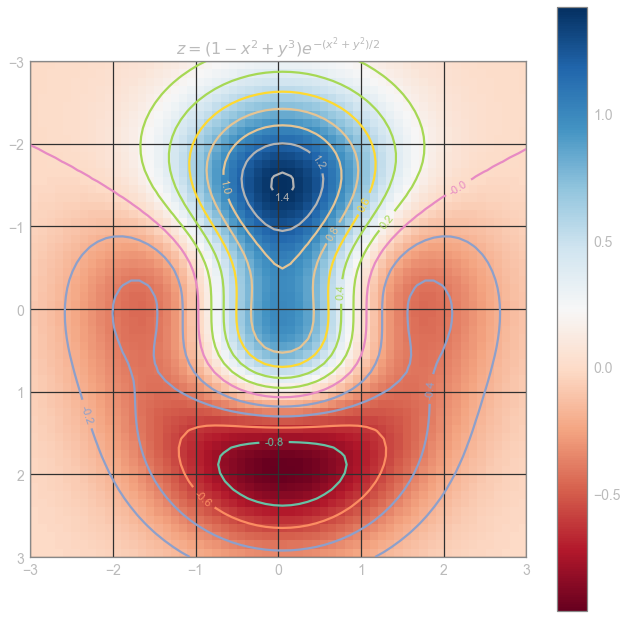

In [9]:
# Visualizacion 1
from matplotlib import pyplot as plt
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
%matplotlib inline

 
x = arange(-3.0,3.0,0.1)
y = arange(-3.0,3.0,0.1)
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

plt.figure(figsize=(10, 10), dpi= 80)
im = imshow(Z,cmap=cm.RdBu, extent=[-3,3,3,-3]) # drawing the function
# adding the Contour lines with labels
cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2,extent=[-3,3,-3,3])
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
# latex fashion title
title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

<IPython.core.display.Javascript object>


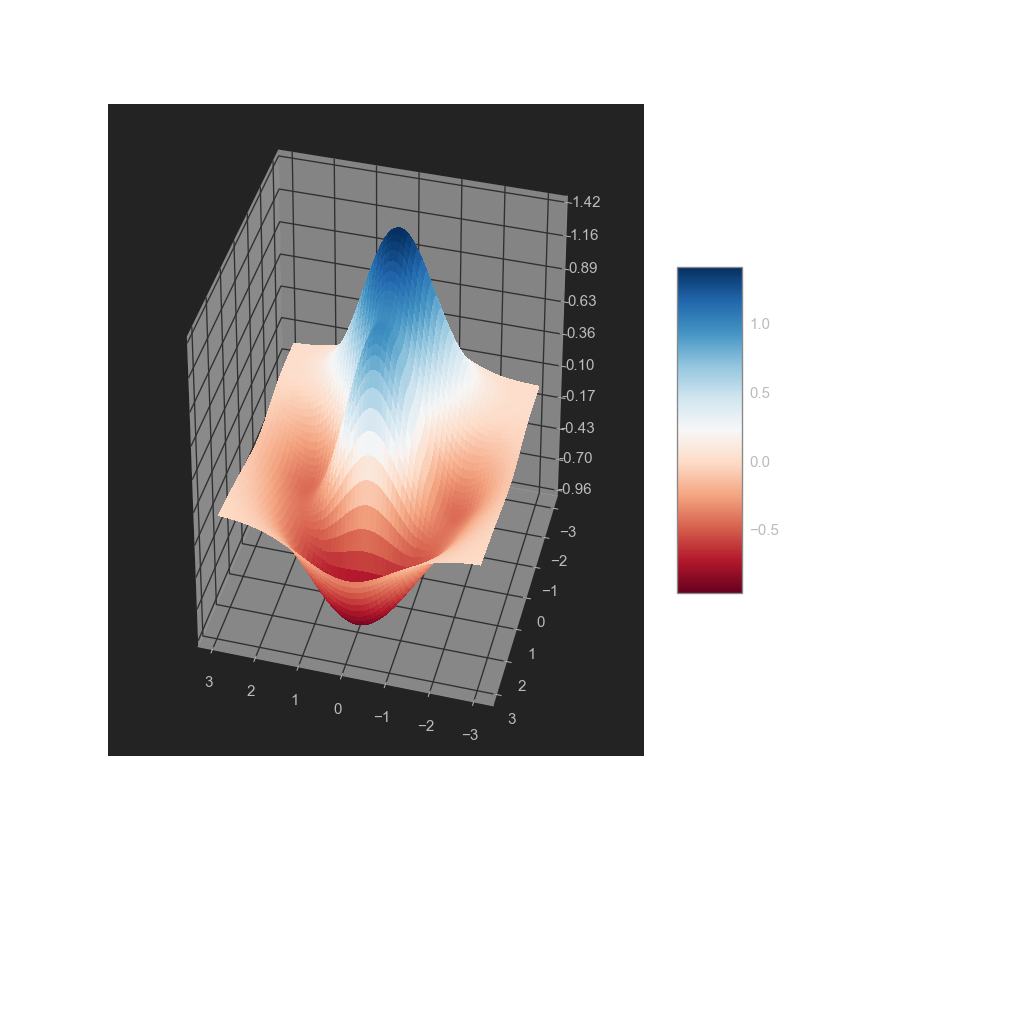

In [6]:
#visualizacion 2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib qt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Data preparation

Estos son los datos con los que se entrena el modelo 

X_init (:,1) Inputs

Y_init (:,1) Respuestas

In [4]:
import numpy as np
np.random.seed(1)

# Punto por punto
#X_init = np.array([[-3,-3], [3,3], [0,0],[3,-3],[-3,3]])
#Y_init = z_func(X_init[:,0],X_init[:,1])

# Puntos en grilla
x = arange(-3.0,3.1,1)
y = arange(-3.0,3.1,1)
X,Y = meshgrid(x, y) # grid of point
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)
X_init=np.append(X,Y,axis=1)
Y_init = z_func(X_init[:,0],X_init[:,1])


In [5]:
#Core Gaussian process con sklearn

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_init, Y_init)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

##  Aquisition Function

In [40]:
import scipy
import numpy

# utility function : UCB

def UCB(x):
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    x1=np.array(x).reshape(-1,2)
    y_pred, sigma = gp.predict(x1, return_std=True)
    return -(y_pred + 1.96 * sigma)

    
def PI(x):
	"""
	Probability of improvement acquisition function
	INPUT:
		- muNew: mean of predicted point in grid
		- stdNew: sigma (square root of variance) of predicted point in grid
		- fMax: observed or predicted maximum value (depending on noise p.19 [Brochu et al. 2010])
		- epsilon: trade-off parameter (>=0)
	OUTPUT:
		- PI: probability of improvement for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning,
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	epsilon = 0.1
	x1=np.array(x).reshape(-1,2)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(Y_init)
    
	Z = (muNew - fMax - epsilon)/stdNew

	return -scipy.stats.norm.cdf(Z) 


def EI(x):
	"""
	Expected improvement acquisition function
	INPUT:
		- muNew: mean of predicted point in grid
		- stdNew: sigma (square root of variance) of predicted point in grid
		- fMax: observed or predicted maximum value (depending on noise p.19 Brochu et al. 2010)
		- epsilon: trade-off parameter (>=0) 
			[Lizotte 2008] suggest setting epsilon = 0.01 (scaled by the signal variance if necessary)  (p.14 [Brochu et al. 2010])		
	OUTPUT:
		- EI: expected improvement for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning, 
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	epsilon = 0.1
	x1=np.array(x).reshape(-1,2)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(Y_init)
	Z = (muNew - fMax - epsilon)/stdNew
	#print(fMax)
	return -((muNew - fMax - epsilon)* scipy.stats.norm.cdf(Z) + stdNew*scipy.stats.norm.pdf(Z))


def UCB2(x, t=X.shape[0]):
	"""
	Upper confidence bound acquisition function
	INPUT:
		- muNew: predicted mean
		- stdNew: sigma (square root of variance) of predicted point in grid
		- t: number of iteration
		- d: dimension of optimization space
		- v: hyperparameter v = 1*
		- delta: small constant (prob of regret)
		*These bounds hold for reasonably smooth kernel functions.
		[Srinivas et al., 2010]
		OUTPUT:
		- UCB: upper confidence bound for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning, 
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	d=2
	v=1
	delta=.1
	delta=.1
	epsilon = 0.01
	x1=np.array(x).reshape(-1,2)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(Y_init)
	Kappa = numpy.sqrt( v* (2*  numpy.log( (t**(d/2. + 2))*(numpy.pi**2)/(3. * delta)  )))
	#print(Kappa)
	return -(muNew + Kappa * stdNew)

#test UCB function
x0 = [(0,  -1.5)]
print(-EI(x0))


[0.00045246]


## Maximization Acquisition Function

In [41]:
from scipy.optimize import minimize
import random

n_iter=40
y_max=max(Y_init)
bounds=np.array([-3,3])
bds=[(-3,3),(-3,3)]
#max_acq=y_max
fPI=0
fEI=0
fUCB=0
fUCB2=0

 # Explore the parameter space more throughly
x_seeds = np.random.uniform(bounds[0], bounds[1],
                                    size=(n_iter, 2))

#print(bounds.shape[0])
for x_try in x_seeds:
        # Find the minimum of minus the acquisition function
 #       print(x_try)
        res_PI=minimize(fun=PI,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_EI=minimize(fun=EI,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_UCB=minimize(fun=UCB,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_UCB2=minimize(fun=UCB2,x0=x_try,method="L-BFGS-B",bounds=bds)
        
#         Store it if better than previous minimum(maximum).
        if fPI is None or  -res_PI.fun[0] >= fPI:
            x_PI_max = res_PI.x
            fPI = -res_PI.fun[0]
        if fEI is None or -res_EI.fun[0] >= fEI:  
            x_EI_max = res_EI.x
            fEI = -res_EI.fun[0]
        if fUCB is None or -res_UCB.fun[0] >= fUCB:   
            x_UCB_max = res_UCB.x        
            fUCB = -res_UCB.fun[0]
        if fUCB2 is None or -res_UCB2.fun[0] >= fUCB2:  
            x_UCB2_max = res_UCB2.x
            fUCB2 = -res_UCB2.fun[0]
            
            

print ("X PI:")
print (x_PI_max) 
print ("X EI:")
print (x_EI_max)
print ("X UCB:")
print (x_UCB_max)
print ("X UCB2:")
print (x_UCB2_max)
# print ("UCB:")
# print (max_acq)
#print(bounds.shape[0])

X PI:
[ 1.48594466e-04 -1.58672098e+00]
X EI:
[-1.61840453e-04 -1.58240272e+00]
X UCB:
[ 2.51055597e-05 -1.58217829e+00]
X UCB2:
[-4.54236807e-05 -1.56282945e+00]


### Plot prediction

C:\Users\megam\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: No contour levels were found within the data range.
C:\Users\megam\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: No contour levels were found within the data range.


0.0660837688847211


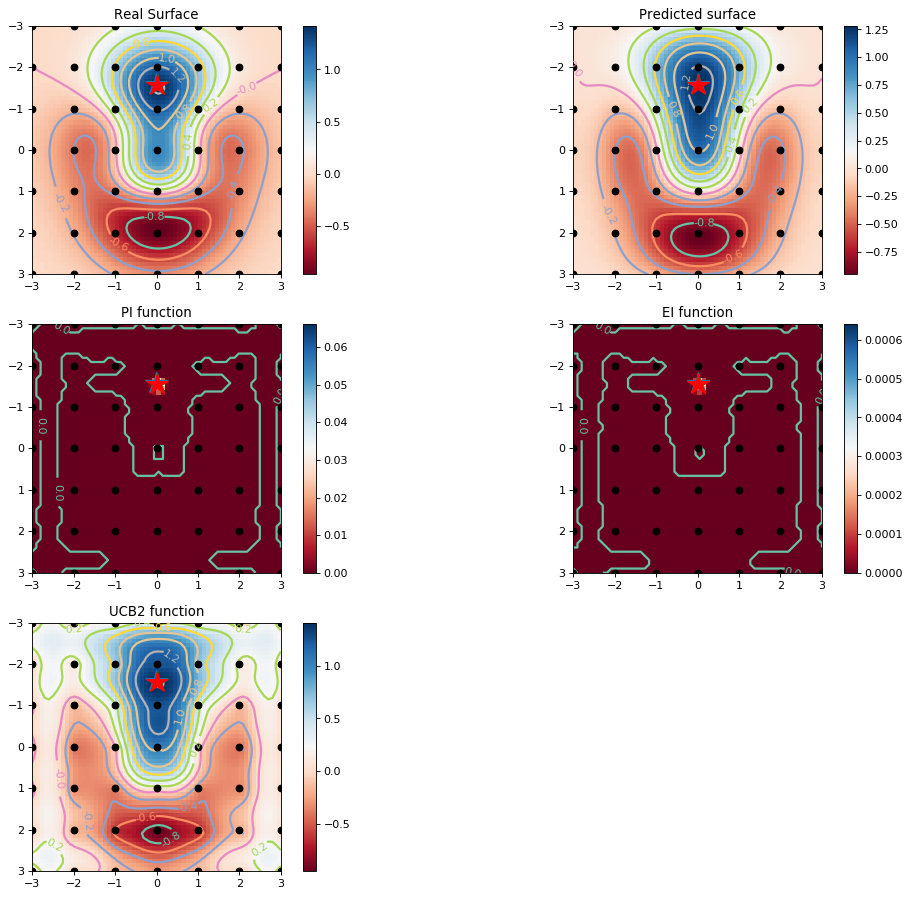

In [44]:
%matplotlib inline

#generate prediction array
x = arange(-3.0,3.0,0.1)
y = arange(-3.0,3.0,0.1)
X,Y = meshgrid(x, y) # grid of point

Xr=X.reshape(-1,1)
Yr=Y.reshape(-1,1)
# z=Z.reshape(-1,1)
Xar=np.append(Xr,Yr,axis=1)

y_pred, sigma = gp.predict(Xar, return_std=True)
y_pred=y_pred.reshape(X.shape)
sigma=sigma.reshape(X.shape)

# Plot
plt.figure(figsize=(16, 14), dpi= 80)
plt.subplot(3,2,2)
im = imshow(y_pred,cmap=cm.RdBu, extent=[-3,3,3,-3]) # drawing the function
# adding the Contour lines with labels
cset = contour(y_pred,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2, extent=[-3,3,-3,3])
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
plt.plot(X_init[:,0],X_init[:,1],'o',color='black')
plt.plot(x_PI_max[0],x_PI_max[1],'*',markersize=20, color='green')
plt.plot(x_EI_max[0],x_EI_max[1],'*',markersize=20)
plt.plot(x_UCB2_max[0],x_UCB2_max[1],'*',markersize=20, color='red')
title('Predicted surface')

plt.subplot(3,2,1)
im = imshow(Z,cmap=cm.RdBu, extent=[-3,3,3,-3]) # drawing the function
# adding the Contour lines with labels
cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2, extent=[-3,3,-3,3])
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
plt.plot(X_init[:,0],X_init[:,1],'o',color='black')
plt.plot(x_PI_max[0],x_PI_max[1],'*',markersize=20, color='green')
plt.plot(x_EI_max[0],x_EI_max[1],'*',markersize=20)
plt.plot(x_UCB2_max[0],x_UCB2_max[1],'*',markersize=20, color='red')
title('Real Surface')

plt.subplot(3,2,3)
im = imshow(-PI(Xar).reshape(X.shape),cmap=cm.RdBu, extent=[-3,3,3,-3]) # drawing the function
# adding the Contour lines with labels
cset = contour(-PI(Xar).reshape(X.shape) ,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2, extent=[-3,3,-3,3])
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
plt.plot(X_init[:,0],X_init[:,1],'o',color='black')
plt.plot(x_PI_max[0],x_PI_max[1],'*',markersize=20, color='green')
plt.plot(x_EI_max[0],x_EI_max[1],'*',markersize=20)
plt.plot(x_UCB2_max[0],x_UCB2_max[1],'*',markersize=20, color='red')
title('PI function')

plt.subplot(3,2,4)
im = imshow(-EI(Xar).reshape(X.shape),cmap=cm.RdBu, extent=[-3,3,3,-3]) # drawing the function
# adding the Contour lines with labels
cset = contour(-EI(Xar).reshape(X.shape) ,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2, extent=[-3,3,-3,3])
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
plt.plot(X_init[:,0],X_init[:,1],'o',color='black')
plt.plot(x_PI_max[0],x_PI_max[1],'*',markersize=20, color='green')
plt.plot(x_EI_max[0],x_EI_max[1],'*',markersize=20)
plt.plot(x_UCB2_max[0],x_UCB2_max[1],'*',markersize=20, color='red')
title('EI function')

plt.subplot(3,2,5)
im = imshow(-UCB2(Xar).reshape(X.shape),cmap=cm.RdBu, extent=[-3,3,3,-3]) # drawing the function
# adding the Contour lines with labels
cset = contour(-UCB2(Xar).reshape(X.shape) ,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2, extent=[-3,3,-3,3])
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
plt.plot(X_init[:,0],X_init[:,1],'o',color='black')
plt.plot(x_PI_max[0],x_PI_max[1],'*',markersize=20, color='green')
plt.plot(x_EI_max[0],x_EI_max[1],'*',markersize=20)
plt.plot(x_UCB2_max[0],x_UCB2_max[1],'*',markersize=20, color='red')
title('UCB2 function')

print(max(-PI(Xar)))